In [1]:
import torch
from torchvision import datasets,transforms
from torch.utils.data import DataLoader

transforms.Compose([...]): Chains multiple transformations together into a single object. When this object is called on an image, it applies the listed transforms sequentially.

#### transforms.ToTensor():
Format Conversion: Converts a PIL image or NumPy array to a PyTorch Tensor.
Reshaping: Changes the image dimensions from (Height, Width, Channels) to (Channels, Height, Width).
### Scaling: Automatically scales pixel values from the range [0, 255] down to [0.0, 1.0].
    transforms.Normalize((0.1307,), (0.3081,)):
The Formula: Performs the operation (input - mean) / std for each channel.
The Numbers: The values 0.1307 (mean) and 0.3081 (standard deviation) are the specific calculated statistics for the MNIST handwriting dataset.
### 
Adjusts the data so it has a mean of 0 and a standard deviation of 1. This helps the neural network converge faster during training

In [2]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3018,))
])
training_dataset=datasets.MNIST(
    root="../../../data",
    train=True,
    download=True,
    transform=transform
)
testing_dataset=datasets.MNIST(
    root="../../../data",
    train=False,
    transform=transform
)

In [3]:
train_loader=DataLoader(training_dataset,batch_size=64,shuffle=True)
test_loader=DataLoader(training_dataset,batch_size=64,shuffle=False)

In [4]:
import torch.nn as nn
import torch.nn.functional as F

In [5]:
class SimpleNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1=nn.Conv2d(1,32,3,padding=1)
        self.conv2=nn.Conv2d(32,64,3,padding=1)
        self.pool=nn.MaxPool2d(2,2)
        self.fc1=nn.Linear(64*7*7,128)
        self.fc2=nn.Linear(128,10)
    
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(x.size(0),-1)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.1400
Epoch 2, Loss: 0.0422
Epoch 3, Loss: 0.0292
Epoch 4, Loss: 0.0210
Epoch 5, Loss: 0.0164


In [7]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


In [8]:
acc = evaluate(model, test_loader)
print(f"Epoch {epoch+1}, Test Accuracy: {acc:.2f}%")


Epoch 5, Test Accuracy: 99.35%


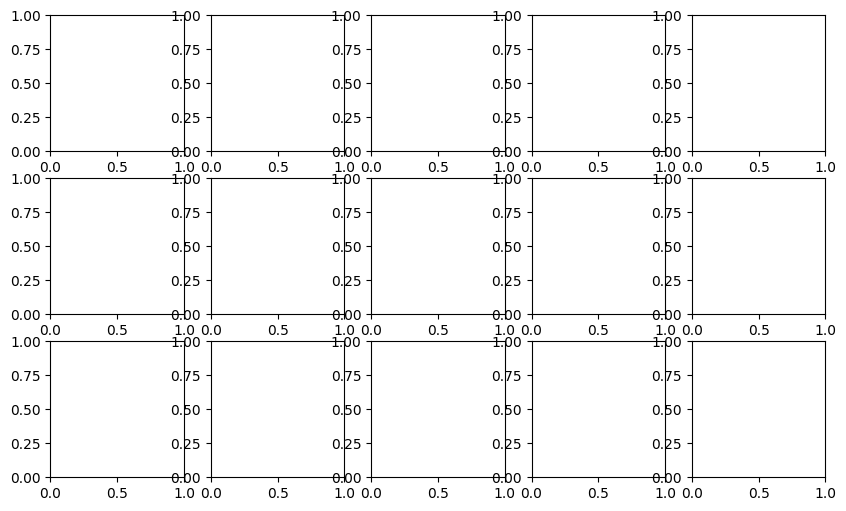

In [9]:
import matplotlib.pyplot as plt

model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, preds = torch.max(outputs, 1)

wrong = preds != labels

fig, axes = plt.subplots(3, 5, figsize=(10,6))
idx = 0
for i in range(len(images)):
    if wrong[i] and idx < 15:
        axes[idx//5, idx%5].imshow(images[i].cpu().squeeze(), cmap="gray")
        axes[idx//5, idx%5].set_title(f"P:{preds[i].item()} T:{labels[i].item()}")
        axes[idx//5, idx%5].axis("off")
        idx += 1
plt.show()
